In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import glob
import warnings

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
import graphviz
import shap

file_dir = '/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'

# drop first N hours of data in each wrfstat file
spin_up = 3

target_hgt = 139

In [2]:
features_df = pd.DataFrame()

# get data capped at height level
lev_i = 6

def get_tminus_df(var, minus_i):
    
    var_df = xr.concat([wrfstat[var][0:minus_i, 0:lev_i]*np.NaN, 
                        wrfstat[var][0:, 0:lev_i]], dim='Time').to_dataframe(var+'_t-'+str(minus_i))
    
    return var_df

for wfile in glob.glob(file_dir+'wrfstat2*')[:2]: 
    
    wrfstat = xr.open_dataset(wfile)

    wrfstat['CSP_WS'] = np.sqrt(wrfstat['CSP_U']**2 + wrfstat['CSP_V']**2)

    time_thres = wrfstat['XTIME'].min().values + np.timedelta64(spin_up, 'h')

    wrfstat = wrfstat.where(wrfstat['XTIME'] >= time_thres, drop=True)
    
    combine_df = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True), 
        [wrfstat['CSP_WS'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_WS', 1), get_tminus_df('CSP_WS', 2),
#          wrfstat['CSP_U'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_U', 1), get_tminus_df('CSP_U', 2),
#          wrfstat['CSP_V'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_V', 1), get_tminus_df('CSP_V', 2),
         wrfstat['CSP_W'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_W', 1), get_tminus_df('CSP_W', 2), 
         wrfstat['CSP_P'][:, 0:lev_i].to_dataframe(), get_tminus_df('CSP_P', 1), get_tminus_df('CSP_P', 2),
         wrfstat['CSP_THDT_LS'][:, 0:lev_i].to_dataframe(), 
         get_tminus_df('CSP_THDT_LS', 1), get_tminus_df('CSP_THDT_LS', 2),
         wrfstat['CSP_QVDT_LS'][:, 0:lev_i].to_dataframe(), 
         get_tminus_df('CSP_QVDT_LS', 1), get_tminus_df('CSP_QVDT_LS', 2)])
    
    features_df = features_df.append(combine_df.unstack())
    
features_df.dropna(inplace=True)

new_col, hgt_list = [], np.empty(0)

for col in features_df.columns.values: 

    lev = int(wrfstat['CSP_Z'][0][col[1]].values)
    new_col.append(col[0]+'_'+str(lev)+'m')
    hgt_list = np.append(hgt_list, lev)

features_df.columns = new_col
hgt_list = np.unique(hgt_list)

# for col in outputs_df.columns.values: 
    
#     lev = int(wrfstat['CSP_Z'][0][col[1]].values)
#     new_outcol.append(col[0]+'_'+str(lev)+'m')
#     hgt_list = np.append(hgt_list, lev)

# outputs_df.columns = new_outcol
# hgt_list = np.unique(hgt_list)

# for col in features_df.columns:
# #     print(col)
#     print(str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m')
    
# #     new_col = col[0]+'_'+str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m'
#     new_col = features_df.columns.values[0][0]+'_'+str(int(wrfstat['CSP_Z'][0][col[1]].values))+'m'
    
#     features_df.rename(columns={col: new_col}, inplace=True)

In [3]:
def run_ml(target_hgt):
    
    print('height:', target_hgt, 'm')

    x_df = features_df.copy(deep=True)

    for h in hgt_list:
        if h >= target_hgt: 
            x_df = x_df[x_df.columns[(x_df.columns.str.contains(str(int(h))) == False)]]

    ws_lev = features_df.columns[(features_df.columns.str.contains('CSP_WS') == True) 
                                 & (features_df.columns.str.contains(str(int(target_hgt))) == True) 
                                 & (features_df.columns.str.contains('-') == False)]
    y = features_df[ws_lev]

    X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.4, random_state=1)
    # print(X_train.shape, X_test.shape)

    ##### xgboost

    xgbregressor = xgb.XGBRegressor(
        learning_rate=0.1,
        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=4,
        subsample=0.8,
    )

    xgbregressor.fit(X_train, y_train)

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=UserWarning)
        y_pred_xgbr = xgbregressor.predict(X_test)

    ##### rf

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        min_samples_split=2,
        min_samples_leaf=1,
    #     bootstrap=True
    )

    rf.fit(X_train, np.ravel(y_train))

    y_pred_rf = rf.predict(X_test)

    explainer = shap.TreeExplainer(rf)
    shap_rf = explainer.shap_values(X_test)

    ##### power law

    x_df = X_test.copy(deep=True)

    u_col = x_df.columns[(x_df.columns.str.contains('CSP_WS') == True) 
                         & (x_df.columns.str.contains('-') == False)]

    lev_list = np.empty(0)

    for u_lev in u_col: 

        lev = u_lev.split('_')[-1].replace('m', '')

        lev_list = np.append(lev_list, float(lev))

    if (target_hgt < lev_list).sum() == 0: 

        levs = np.sort(lev_list)[-2:]

        alpha = np.log(x_df['CSP_WS_'+str(int(levs[1]))+'m']/x_df['CSP_WS_'+str(int(levs[0]))+'m'])\
                /np.log(levs[1]/levs[0])

        x_df['CSP_WS_'+str(int(target_hgt))+'m'] = x_df['CSP_WS_'+str(int(levs[1]))+'m']\
                                                   *(target_hgt/levs[1])**alpha

    print('MSE:')
    print('XGBoost:', np.round(mean_squared_error(y_test, y_pred_xgbr), 5))
    print('random forest:', np.round(mean_squared_error(y_test, y_pred_rf), 5))
    print('power law: ', np.round(mean_squared_error(
        y_test, x_df['CSP_WS_'+str(int(target_hgt))+'m']), 5))

    fig, ax = plt.subplots(figsize=(6, 3))
    xgb.plot_importance(xgbregressor, ax=ax, max_num_features=10, grid=False, 
                        title='XGBoost Regression feature importance')
    plt.show()

    shap.summary_plot(shap_rf, X_test, plot_type='bar', max_display=10, plot_size=(6, 3))

height: 77.0 m
MSE:
XGBoost: 0.003
random forest: 0.00156
power law:  1.2608


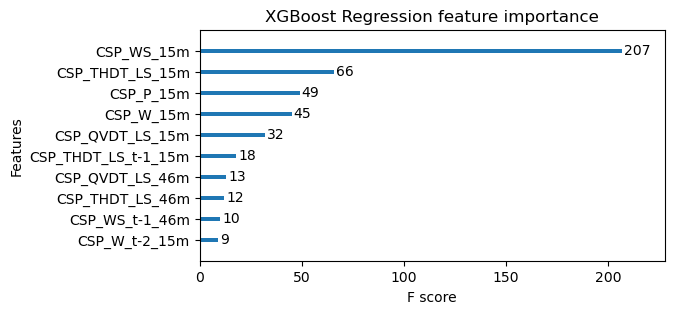

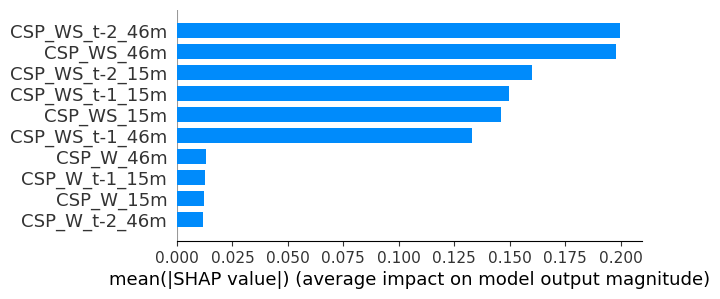

height: 108.0 m
MSE:
XGBoost: 0.00347
random forest: 0.00126
power law:  0.03142


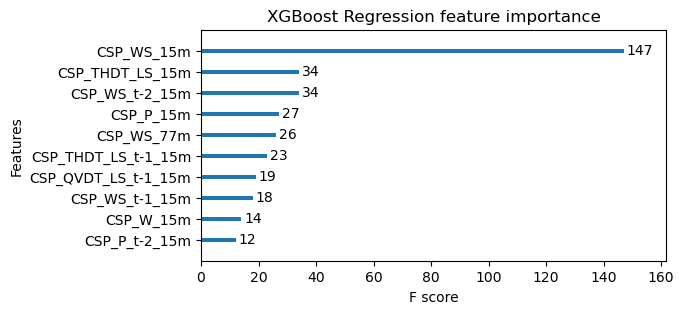

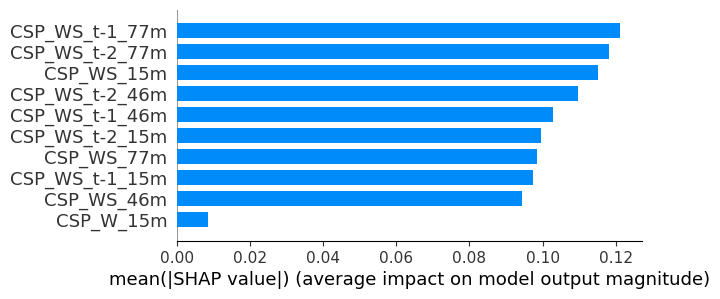

height: 139.0 m
MSE:
XGBoost: 0.00392
random forest: 0.00121
power law:  0.00284


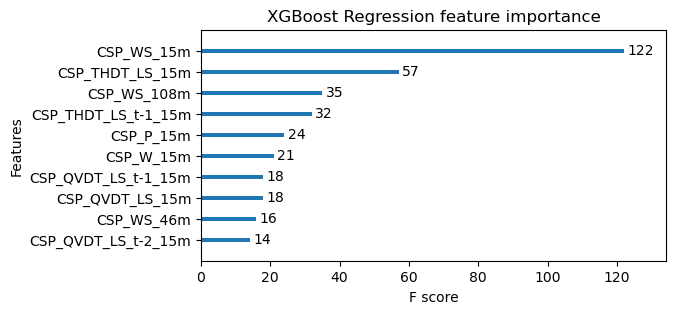

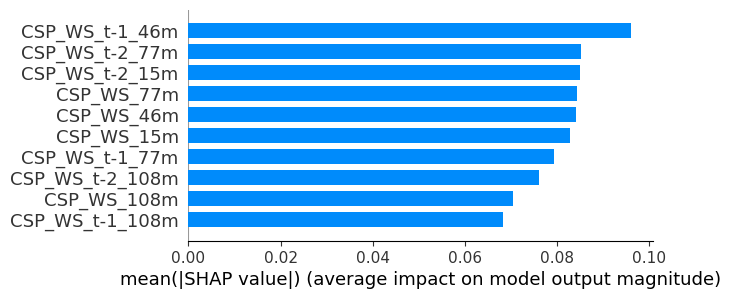

height: 169.0 m
MSE:
XGBoost: 0.00385
random forest: 0.0013
power law:  0.00056


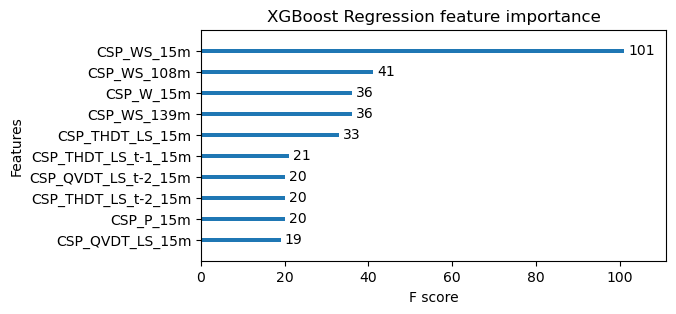

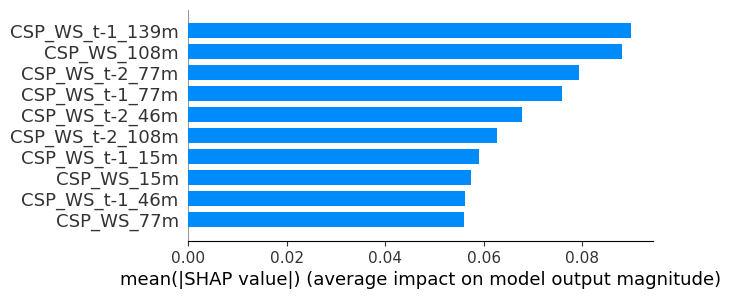

In [4]:
for h in hgt_list[2:]:
    run_ml(h)

In [3]:
features_df

,CSP_WS_15m,CSP_WS_46m,CSP_WS_77m,CSP_WS_108m,CSP_WS_139m,CSP_WS_169m,CSP_WS_t-1_15m,CSP_WS_t-1_46m,CSP_WS_t-1_77m,CSP_WS_t-1_108m,...,CSP_QVDT_LS_t-1_77m,CSP_QVDT_LS_t-1_108m,CSP_QVDT_LS_t-1_139m,CSP_QVDT_LS_t-1_169m,CSP_QVDT_LS_t-2_15m,CSP_QVDT_LS_t-2_46m,CSP_QVDT_LS_t-2_77m,CSP_QVDT_LS_t-2_108m,CSP_QVDT_LS_t-2_139m,CSP_QVDT_LS_t-2_169m
Time,,,,,,,,,,,,,,,,,,,,,
2,6.422850,7.367338,7.740980,7.913311,7.991522,8.030063,6.445815,7.401252,7.784361,7.957997,...,1.130310e-08,1.121132e-08,1.112331e-08,1.116125e-08,1.129425e-08,1.162816e-08,1.165475e-08,1.156977e-08,1.148833e-08,1.152396e-08
3,6.371682,7.310240,7.684707,7.860444,7.943762,7.988800,6.422850,7.367338,7.740980,7.913311,...,1.099814e-08,1.089717e-08,1.080089e-08,1.083641e-08,1.095265e-08,1.128515e-08,1.130310e-08,1.121132e-08,1.112331e-08,1.116125e-08
4,6.344862,7.284563,7.662221,7.841904,7.926730,7.969504,6.371682,7.310240,7.684707,7.860444,...,1.070904e-08,1.060967e-08,1.051671e-08,1.055711e-08,1.066188e-08,1.099166e-08,1.099814e-08,1.089717e-08,1.080089e-08,1.083641e-08
5,6.293921,7.222752,7.606291,7.799590,7.897383,7.949692,6.344862,7.284563,7.662221,7.841904,...,1.042417e-08,1.031674e-08,1.021194e-08,1.024966e-08,1.037313e-08,1.070588e-08,1.070904e-08,1.060967e-08,1.051671e-08,1.055711e-08
6,6.284677,7.215151,7.596813,7.786468,7.880503,7.929264,6.293921,7.222752,7.606291,7.799590,...,1.013919e-08,1.004326e-08,9.948780e-09,9.994689e-09,1.008342e-08,1.042245e-08,1.042417e-08,1.031674e-08,1.021194e-08,1.024966e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.378251,3.771201,5.013735,5.336427,5.476988,5.611134,0.432483,3.797231,5.009902,5.328268,...,3.086067e-09,4.142739e-09,4.288009e-09,4.200801e-09,2.783190e-09,1.809420e-09,3.081481e-09,3.962712e-09,4.073795e-09,3.968705e-09
69,0.329718,3.745493,5.019078,5.346721,5.479195,5.608771,0.378251,3.771201,5.013735,5.336427,...,3.104123e-09,4.434798e-09,4.628949e-09,4.553809e-09,2.789920e-09,1.644518e-09,3.086067e-09,4.142739e-09,4.288009e-09,4.200801e-09
70,0.287312,3.721530,5.022686,5.358337,5.483729,5.606841,0.329718,3.745493,5.019078,5.346721,...,3.092537e-09,4.726703e-09,4.978189e-09,4.914286e-09,2.794548e-09,1.372111e-09,3.104123e-09,4.434798e-09,4.628949e-09,4.553809e-09


In [80]:
hgt_list

array([ 15.,  46.,  77., 108., 139., 169.])

In [81]:
x_df = features_df.copy(deep=True)

for h in hgt_list:
    if h >= target_hgt: 
        x_df = x_df[x_df.columns[(x_df.columns.str.contains(str(int(h))) == False)]]

ws_lev = features_df.columns[(features_df.columns.str.contains('CSP_WS') == True) 
                             & (features_df.columns.str.contains(str(target_hgt)) == True) 
                             & (features_df.columns.str.contains('-') == False)]
y = features_df[ws_lev]

X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.4, random_state=1)
print(X_train.shape, X_test.shape)

(85, 60) (57, 60)


height: 77.0 m
MSE:
XGBoost: 0.003
random forest: 0.00172
power law:  1.2608


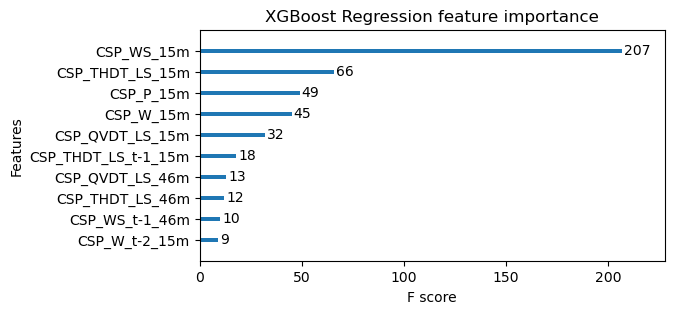

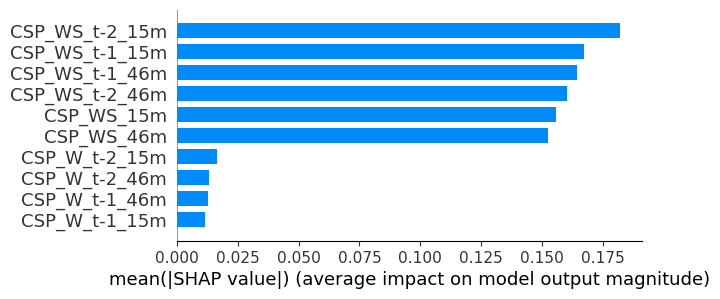

height: 108.0 m
MSE:
XGBoost: 0.00347
random forest: 0.00152
power law:  0.03142


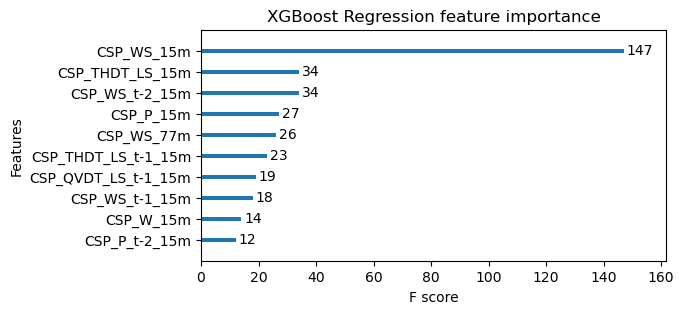

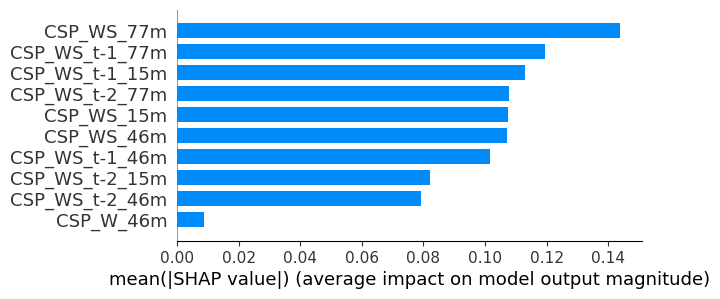

height: 139.0 m
MSE:
XGBoost: 0.00392
random forest: 0.00132
power law:  0.00284


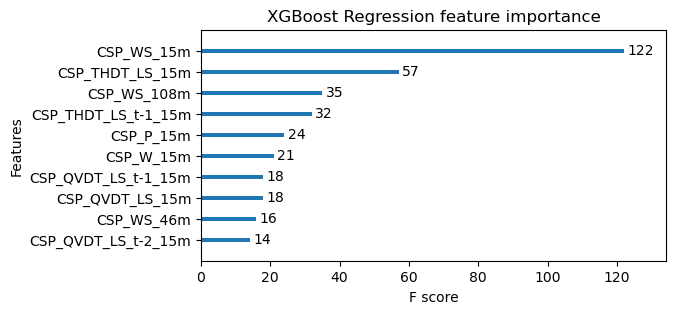

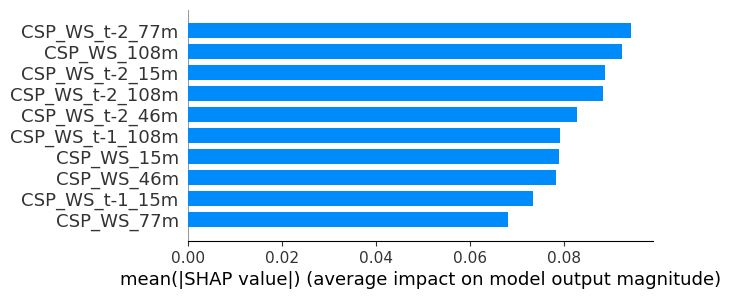

height: 169.0 m
MSE:
XGBoost: 0.00385
random forest: 0.00155
power law:  0.00056


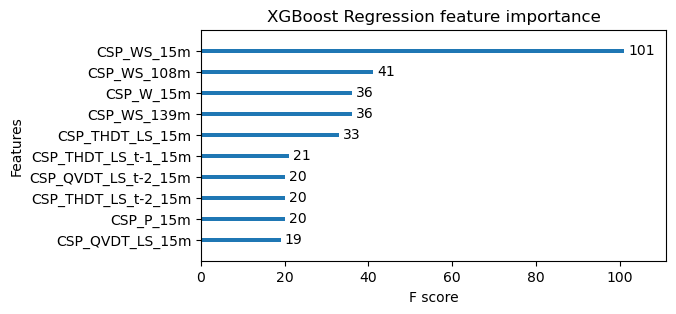

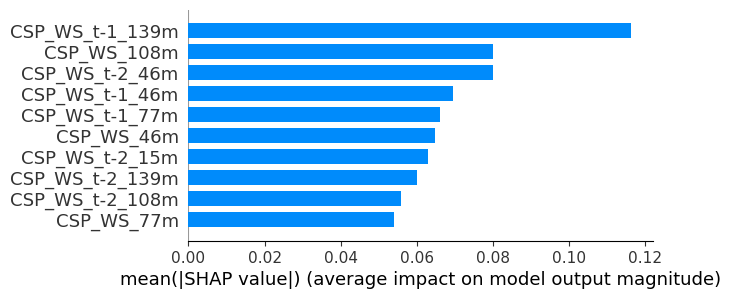

## XGBoost

In [89]:
regressor = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=4,
    subsample=0.8,
)

regressor.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=UserWarning)
    y_pred = regressor.predict(X_test)
    
print(mean_squared_error(y_test, y_pred))

0.003922384


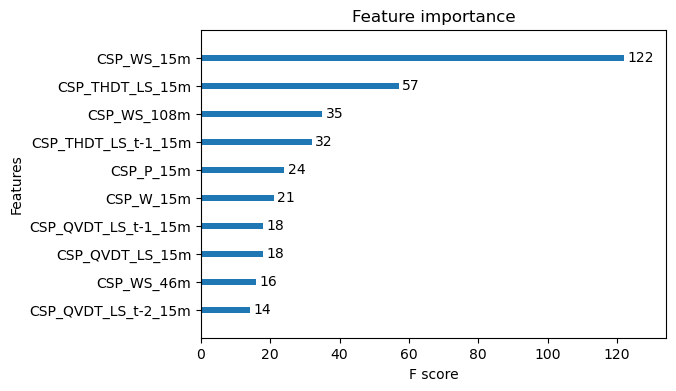

In [103]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(regressor, ax=ax, max_num_features=10, grid=False)
plt.show()

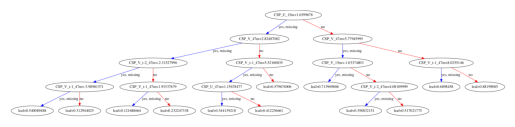

In [9]:
# need to install graphviz on conda (Python) and brew (system)
xgb.plot_tree(regressor, num_trees=1)
plt.show()

In [59]:
regressor = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [2, 5, 10],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.6, 0.7, 0.8]
}

# Fitting 10 folds for each of 1458 candidates, totalling 14580 fits
# Best: -0.013091 using {'colsample_bytree': 0.7, 'learning_rate': 0.1, 
#                        'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 1.2, 
#                        'reg_lambda': 1.3, 'subsample': 0.8}

grid_search = GridSearchCV(regressor, param_grid, 
                           scoring='neg_mean_squared_error', n_jobs=-1, cv=10, verbose=2)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits
Best: -0.013091 using {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 1.2, 'reg_lambda': 1.3, 'subsample': 0.8}
-4.467926 (0.469339) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.6}
-4.457242 (0.472684) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.7}
-4.448175 (0.461980) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.8}
-4.473180 (0.470229) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.2, 'subsample': 0.6}
-4.462707 (0.473925) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_esti

In [112]:
np.ravel(y_train)

array([5.720072 , 5.9615774, 5.9597907, 5.4856896, 6.2293425, 6.7977977,
       5.904494 , 6.051206 , 6.5163484, 8.664351 , 6.658519 , 5.734657 ,
       8.628624 , 7.9095845, 7.602866 , 7.929641 , 7.639177 , 7.7785654,
       6.0825696, 7.3036833, 6.848031 , 5.49301  , 8.0182085, 8.1307745,
       5.730348 , 5.5877976, 5.7944283, 6.15632  , 5.509915 , 5.613386 ,
       8.428309 , 5.4791946, 7.073936 , 5.7263727, 8.011314 , 8.76387  ,
       7.0359797, 8.913546 , 6.2983546, 8.052804 , 8.84154  , 6.8863416,
       8.093467 , 5.4734178, 6.3549476, 5.840235 , 6.490689 , 8.094077 ,
       5.7438273, 7.8973827, 5.4731765, 7.89939  , 5.483729 , 6.642885 ,
       6.615229 , 5.5368676, 8.299257 , 7.875574 , 8.857798 , 5.7606792,
       7.9915223, 7.943762 , 5.8684816, 8.129976 , 5.744909 , 5.7288175,
       7.8702087, 7.8816743, 6.689623 , 8.010208 , 8.528272 , 7.4173107,
       5.734823 , 6.4231057, 6.957466 , 8.103742 , 8.054981 , 8.0891485,
       5.4994264, 8.910679 , 5.4732804, 5.476988 , 

## Random forest

In [114]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
#     bootstrap=True
)

rf.fit(X_train, np.ravel(y_train))

# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=UserWarning)
y_pred = rf.predict(X_test)

print(mean_squared_error(y_test, y_pred))

0.0013524537617822352


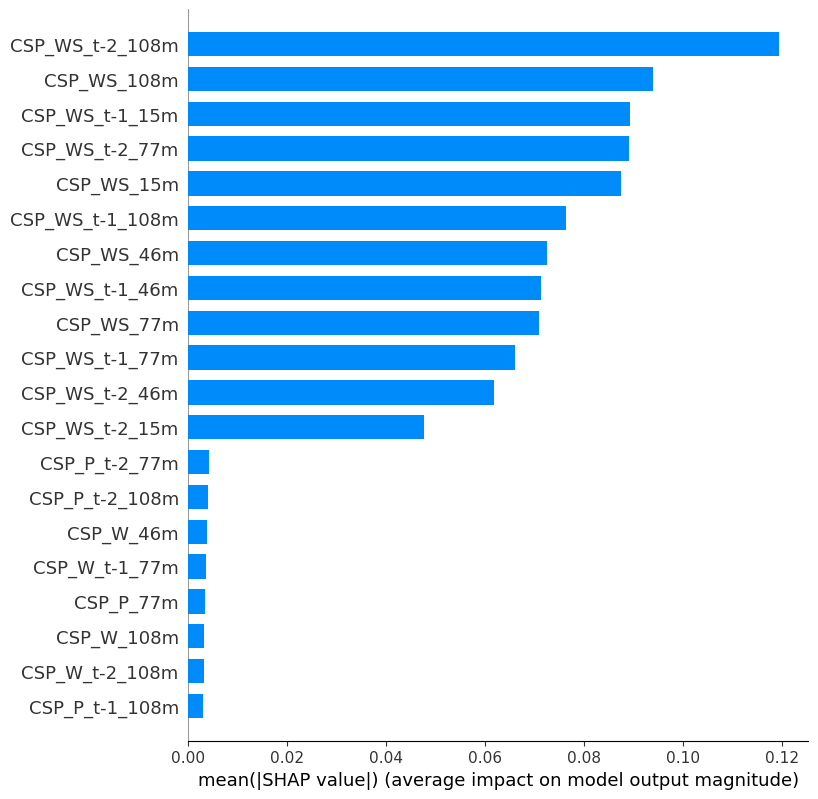

In [115]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

In [198]:
rf = RandomForestRegressor()

param_dist = {'max_depth': [3, None],
              'max_features': sp_randint(1, X_train.shape[1]),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap': [True, False],
              'n_estimators': sp_randint(100, 500)}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, 
                                   n_iter=10, cv=10, random_state=42)
random_search.fit(X_train, y_train)
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Best: -0.013253 using {'bootstrap': False, 'max_depth': None, 'max_features': 21, 'min_samples_split': 2, 'n_estimators': 413}


## Power law

In [84]:
x_df = X_test.copy(deep=True)

u_col = x_df.columns[(x_df.columns.str.contains('CSP_WS') == True) & (x_df.columns.str.contains('-') == False)]

lev_list = np.empty(0)

for u_lev in u_col: 
    
    lev = u_lev.split('_')[-1].replace('m', '')
#     v_lev = X_test.columns[(X_test.columns.str.contains('CSP_V') == True) 
#                            & (X_test.columns.str.contains(lev) == True) 
#                            & (X_test.columns.str.contains('-') == False)]

#     x_df['CSP_WS_'+lev+'m'] = np.sqrt(X_test[u_lev]**2 + X_test[v_lev].iloc[:, 0]**2)

    lev_list = np.append(lev_list, float(lev))
    
# target_hgt = wrfstat['CSP_Z'][0, lev_i].values

print(target_hgt)

if (target_hgt < lev_list).sum() == 0: 
    
    levs = np.sort(lev_list)[-2:]
    print(levs)
    
    alpha = np.log(x_df['CSP_WS_'+str(int(levs[1]))+'m']/x_df['CSP_WS_'+str(int(levs[0]))+'m'])\
            /np.log(levs[1]/levs[0])
    
    x_df['CSP_WS_'+str(int(target_hgt))+'m'] = x_df['CSP_WS_'+str(int(levs[1]))+'m']*(target_hgt/levs[1])**alpha
    
print(mean_squared_error(y_test, x_df['CSP_WS_'+str(int(target_hgt))+'m']))

139
[ 77. 108.]
0.002836934


In [85]:
y_test.head()

,CSP_WS_139m
Time,
9,8.896878
47,5.997043
33,7.861533
7,7.879871
56,5.559830


In [86]:
x_df.head()

,CSP_WS_15m,CSP_WS_46m,CSP_WS_77m,CSP_WS_108m,CSP_WS_t-1_15m,CSP_WS_t-1_46m,CSP_WS_t-1_77m,CSP_WS_t-1_108m,CSP_WS_t-2_15m,CSP_WS_t-2_46m,...,CSP_QVDT_LS_108m,CSP_QVDT_LS_t-1_15m,CSP_QVDT_LS_t-1_46m,CSP_QVDT_LS_t-1_77m,CSP_QVDT_LS_t-1_108m,CSP_QVDT_LS_t-2_15m,CSP_QVDT_LS_t-2_46m,CSP_QVDT_LS_t-2_77m,CSP_QVDT_LS_t-2_108m,CSP_WS_139m
Time,,,,,,,,,,,,,,,,,,,,,
9,7.034485,8.110259,8.556337,8.783040,7.046247,8.128329,8.573781,8.789125,7.051753,8.126785,...,-2.900144e-08,-2.893949e-08,-3.049060e-08,-3.053996e-08,-3.008580e-08,-3.004218e-08,-3.152493e-08,-3.157218e-08,-3.112179e-08,8.956030
47,4.480413,5.271383,5.653875,5.870313,4.529133,5.315902,5.689773,5.902193,4.584741,5.369334,...,7.349754e-09,7.231130e-09,7.417086e-09,7.433741e-09,7.387693e-09,7.272621e-09,7.469073e-09,7.478616e-09,7.425511e-09,6.037121
33,6.184960,7.114207,7.512702,7.734944,6.198674,7.130495,7.535726,7.766192,6.217495,7.156616,...,-1.174095e-08,-1.198203e-08,-1.133047e-08,-1.136869e-08,-1.155382e-08,-1.184320e-08,-1.110552e-08,-1.112430e-08,-1.131580e-08,7.904975
7,6.296552,7.222548,7.598208,7.786027,6.284677,7.215151,7.596813,7.786468,6.293921,7.222752,...,9.243406e-09,9.501054e-09,9.842221e-09,9.842393e-09,9.742739e-09,9.792672e-09,1.013391e-08,1.013919e-08,1.004326e-08,7.929131
56,2.133451,4.251646,4.975227,5.344156,2.512255,4.363558,5.019420,5.374279,3.002467,4.496006,...,4.523575e-09,4.734720e-09,4.689849e-09,4.735186e-09,4.752544e-09,5.085875e-09,5.089811e-09,5.088517e-09,5.088084e-09,5.637026


In [35]:
u_col

Index(['CSP_WS_15m', 'CSP_WS_46m'], dtype='object')

In [36]:
lev_list

array([15., 46.])

In [37]:
(target_hgt < lev_list).sum() 

0

In [25]:
x_df

,CSP_WS_15m,CSP_WS_46m,CSP_WS_t-1_15m,CSP_WS_t-1_46m,CSP_WS_t-2_15m,CSP_WS_t-2_46m,CSP_W_15m,CSP_W_46m,CSP_W_t-1_15m,CSP_W_t-1_46m,...,CSP_THDT_LS_t-1_15m,CSP_THDT_LS_t-1_46m,CSP_THDT_LS_t-2_15m,CSP_THDT_LS_t-2_46m,CSP_QVDT_LS_15m,CSP_QVDT_LS_46m,CSP_QVDT_LS_t-1_15m,CSP_QVDT_LS_t-1_46m,CSP_QVDT_LS_t-2_15m,CSP_QVDT_LS_t-2_46m
Time,,,,,,,,,,,,,,,,,,,,,
9,7.034485,8.110259,7.046247,8.128329,7.051753,8.126785,0.000192,0.000524,0.000183,0.000502,...,-7.812559e-06,-1.034182e-05,-8.648234e-06,-1.103053e-05,-2.783113e-08,-2.942458e-08,-2.893949e-08,-3.049060e-08,-3.004218e-08,-3.152493e-08
47,4.480413,5.271383,4.529133,5.315902,4.584741,5.369334,0.000029,0.000082,0.000038,0.000108,...,1.446050e-05,1.456906e-05,1.738332e-05,1.752577e-05,7.188903e-09,7.364009e-09,7.231130e-09,7.417086e-09,7.272621e-09,7.469073e-09
33,6.184960,7.114207,6.198674,7.130495,6.217495,7.156616,0.000195,0.000528,0.000200,0.000542,...,-2.154462e-06,-1.404023e-06,-2.777976e-07,5.816759e-07,-1.211861e-08,-1.153798e-08,-1.198203e-08,-1.133047e-08,-1.184320e-08,-1.110552e-08
7,6.296552,7.222548,6.284677,7.215151,6.293921,7.222752,0.000146,0.000397,0.000137,0.000374,...,-1.749451e-06,-1.285218e-06,-2.206384e-06,-1.748239e-06,9.019525e-09,9.348183e-09,9.501054e-09,9.842221e-09,9.792672e-09,1.013391e-08
56,2.133451,4.251646,2.512255,4.363558,3.002467,4.496006,-0.000026,-0.000061,-0.000024,-0.000056,...,-1.968559e-05,-1.966375e-05,-1.615404e-05,-1.617198e-05,4.460206e-09,4.362549e-09,4.734720e-09,4.689849e-09,5.085875e-09,5.089811e-09
47,5.245589,6.058947,5.321595,6.140772,5.402918,6.231350,0.000089,0.000245,0.000100,0.000272,...,-2.378245e-05,-2.385083e-05,-2.345411e-05,-2.352510e-05,-7.984732e-09,-8.037389e-09,-8.528304e-09,-8.581971e-09,-9.071522e-09,-9.126397e-09
16,6.348314,7.280484,6.365676,7.302944,6.349856,7.274570,0.000205,0.000551,0.000201,0.000544,...,-1.812027e-06,-1.666035e-06,-1.462752e-06,-1.299390e-06,9.363074e-10,1.031677e-09,2.155273e-09,2.263190e-09,3.373315e-09,3.492395e-09
46,5.321595,6.140772,5.402918,6.231350,5.472098,6.304691,0.000100,0.000272,0.000109,0.000296,...,-2.345411e-05,-2.352510e-05,-2.312546e-05,-2.319918e-05,-8.528304e-09,-8.581971e-09,-9.071522e-09,-9.126397e-09,-9.614813e-09,-9.670062e-09
4,6.871342,7.892187,6.720558,7.705202,6.507604,7.450828,0.000151,0.000414,0.000143,0.000389,...,-1.235193e-05,-1.396395e-05,-1.331111e-05,-1.475385e-05,-3.104598e-08,-3.228719e-08,-3.125133e-08,-3.244586e-08,-3.145749e-08,-3.260930e-08


In [137]:
x_df

,CSP_U_15m,CSP_U_47m,CSP_U_t-1_15m,CSP_U_t-1_47m,CSP_U_t-2_15m,CSP_U_t-2_47m,CSP_V_15m,CSP_V_47m,CSP_V_t-1_15m,CSP_V_t-1_47m,...,CSP_THDT_LS_t-2_47m,CSP_QVDT_LS_15m,CSP_QVDT_LS_47m,CSP_QVDT_LS_t-1_15m,CSP_QVDT_LS_t-1_47m,CSP_QVDT_LS_t-2_15m,CSP_QVDT_LS_t-2_47m,CSP_WS_15m,CSP_WS_47m,CSP_WS_78m
Time,,,,,,,,,,,,,,,,,,,,,
16,2.759368,3.226943,2.772498,3.241255,2.801765,3.275296,8.593307,10.003632,8.672577,10.100615,...,-2.445863e-05,3.162013e-08,3.193158e-08,3.350019e-08,3.382171e-08,3.538492e-08,3.571675e-08,9.025466,10.511223,11.247286
14,-2.491554,-2.776735,-2.488374,-2.772833,-2.487083,-2.769011,-0.310252,-0.345264,-0.281344,-0.313217,...,-4.685420e-05,-8.175148e-10,-1.123881e-09,-4.872155e-10,-7.814772e-10,-4.238390e-10,-6.951743e-10,2.510797,2.798118,2.936059
24,3.458544,3.992806,3.503297,4.047067,3.510150,4.056444,4.885180,5.644583,4.940576,5.712675,...,8.536132e-06,-2.966156e-09,-4.172583e-09,-4.573742e-09,-5.896511e-09,-6.179522e-09,-7.602373e-09,5.985526,6.914030,7.371350
18,-0.556138,-0.616339,-0.569252,-0.626987,-0.545107,-0.604844,1.298139,1.436531,1.381173,1.528219,...,-8.477947e-08,4.464969e-09,4.535210e-09,4.126628e-09,4.133987e-09,3.788372e-09,3.730095e-09,1.412251,1.563168,1.635269
46,-0.716941,-0.823238,-0.722952,-0.829531,-0.701325,-0.806462,4.021403,4.614149,4.076398,4.671782,...,-9.672311e-05,1.008884e-08,9.510554e-09,1.202787e-08,1.149185e-08,1.396393e-08,1.346022e-08,4.084812,4.687013,4.982207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,-3.413802,-3.962205,-3.455351,-4.000852,-3.482075,-4.028667,-3.534173,-4.096078,-3.553500,-4.120073,...,6.373582e-06,4.083728e-09,4.233459e-09,3.447512e-09,3.560312e-09,2.994133e-09,3.083027e-09,4.913698,5.698853,6.086680
52,-0.406128,-0.470133,-0.409657,-0.472719,-0.400982,-0.463745,4.077456,4.746090,4.120335,4.787053,...,-5.729086e-05,1.523567e-08,1.479055e-08,1.495529e-08,1.450476e-08,1.467294e-08,1.420829e-08,4.097631,4.769319,5.101939
26,2.583134,2.962316,2.753967,3.168886,2.914855,3.352592,5.298970,6.090140,5.434222,6.240026,...,-8.730543e-06,5.955330e-09,6.258582e-09,7.754921e-09,8.118765e-09,9.711043e-09,1.010964e-08,5.895055,6.772380,7.202811


In [ ]:
x_df['CSP_WS_'+str(int(target_hgt))+'m'], y_test

In [133]:
print(mean_squared_error(y_test, x_df['CSP_WS_'+str(int(target_hgt))+'m']))

0.80492806


In [111]:
lev_list = np.sort(lev_list)

array([15., 47.])

In [109]:
lev_list

array([15., 47.])

In [110]:
type(lev_list)

numpy.ndarray

In [127]:
target_hgt = wrfstat['CSP_Z'][0, lev_i].values

if (target_hgt < lev_list).sum() == 0: 
    
    levs = np.sort(lev_list)[-2:]
    print(levs)
    
    levs[0]
    
    alpha = np.log(x_df['CSP_WS_'+str(int(levs[1]))+'m']/x_df['CSP_WS_'+str(int(levs[0]))+'m'])\
            /np.log(levs[1]/levs[0])
    print(alpha)
    
    x_df['CSP_WS_'+str(int(target_hgt))+'m'] = x_df['CSP_WS_'+str(int(levs[1]))+'m']*(target_hgt/levs[1])**alpha

[15. 47.]
Time
16    0.133433
14    0.094867
24    0.126266
18    0.088897
46    0.120410
        ...   
38    0.129795
52    0.132908
26    0.121477
56    0.133341
48    0.128029
Length: 1307, dtype: float32


In [128]:
x_df

,CSP_U_15m,CSP_U_47m,CSP_U_t-1_15m,CSP_U_t-1_47m,CSP_U_t-2_15m,CSP_U_t-2_47m,CSP_V_15m,CSP_V_47m,CSP_V_t-1_15m,CSP_V_t-1_47m,...,CSP_THDT_LS_t-2_47m,CSP_QVDT_LS_15m,CSP_QVDT_LS_47m,CSP_QVDT_LS_t-1_15m,CSP_QVDT_LS_t-1_47m,CSP_QVDT_LS_t-2_15m,CSP_QVDT_LS_t-2_47m,CSP_WS_15m,CSP_WS_47m,CSP_WS_78m
Time,,,,,,,,,,,,,,,,,,,,,
16,2.759368,3.226943,2.772498,3.241255,2.801765,3.275296,8.593307,10.003632,8.672577,10.100615,...,-2.445863e-05,3.162013e-08,3.193158e-08,3.350019e-08,3.382171e-08,3.538492e-08,3.571675e-08,9.025466,10.511223,11.247286
14,-2.491554,-2.776735,-2.488374,-2.772833,-2.487083,-2.769011,-0.310252,-0.345264,-0.281344,-0.313217,...,-4.685420e-05,-8.175148e-10,-1.123881e-09,-4.872155e-10,-7.814772e-10,-4.238390e-10,-6.951743e-10,2.510797,2.798118,2.936059
24,3.458544,3.992806,3.503297,4.047067,3.510150,4.056444,4.885180,5.644583,4.940576,5.712675,...,8.536132e-06,-2.966156e-09,-4.172583e-09,-4.573742e-09,-5.896511e-09,-6.179522e-09,-7.602373e-09,5.985526,6.914030,7.371350
18,-0.556138,-0.616339,-0.569252,-0.626987,-0.545107,-0.604844,1.298139,1.436531,1.381173,1.528219,...,-8.477947e-08,4.464969e-09,4.535210e-09,4.126628e-09,4.133987e-09,3.788372e-09,3.730095e-09,1.412251,1.563168,1.635269
46,-0.716941,-0.823238,-0.722952,-0.829531,-0.701325,-0.806462,4.021403,4.614149,4.076398,4.671782,...,-9.672311e-05,1.008884e-08,9.510554e-09,1.202787e-08,1.149185e-08,1.396393e-08,1.346022e-08,4.084812,4.687013,4.982207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,-3.413802,-3.962205,-3.455351,-4.000852,-3.482075,-4.028667,-3.534173,-4.096078,-3.553500,-4.120073,...,6.373582e-06,4.083728e-09,4.233459e-09,3.447512e-09,3.560312e-09,2.994133e-09,3.083027e-09,4.913698,5.698853,6.086680
52,-0.406128,-0.470133,-0.409657,-0.472719,-0.400982,-0.463745,4.077456,4.746090,4.120335,4.787053,...,-5.729086e-05,1.523567e-08,1.479055e-08,1.495529e-08,1.450476e-08,1.467294e-08,1.420829e-08,4.097631,4.769319,5.101939
26,2.583134,2.962316,2.753967,3.168886,2.914855,3.352592,5.298970,6.090140,5.434222,6.240026,...,-8.730543e-06,5.955330e-09,6.258582e-09,7.754921e-09,8.118765e-09,9.711043e-09,1.010964e-08,5.895055,6.772380,7.202811


In [26]:
u_col = x_df.columns[(x_df.columns.str.contains('CSP_U')==True) & (x_df.columns.str.contains('-')==False)]
u_col

Index(['CSP_U_15m', 'CSP_U_47m'], dtype='object')

In [33]:
float(u_col[0].split('_')[-1].replace('m', ''))

15.0

In [73]:
for u_lev in u_col: 
    lev = u_lev.split('_')[-1].replace('m', '')
    v_lev = X_test.columns[(X_test.columns.str.contains('CSP_V')==True) 
                           & (X_test.columns.str.contains(lev)==True) & (X_test.columns.str.contains('-')==False)]
#     print(u_lev, v_lev)
    x_df['CSP_WS_'+lev+'m'] = np.sqrt(X_test[u_lev]**2 + X_test[v_lev].iloc[:, 0]**2)

CSP_U_15m Index(['CSP_V_15m'], dtype='object')
CSP_U_47m Index(['CSP_V_47m'], dtype='object')


In [74]:
x_df

,CSP_U_15m,CSP_U_47m,CSP_U_t-1_15m,CSP_U_t-1_47m,CSP_U_t-2_15m,CSP_U_t-2_47m,CSP_V_15m,CSP_V_47m,CSP_V_t-1_15m,CSP_V_t-1_47m,...,CSP_THDT_LS_t-2_15m,CSP_THDT_LS_t-2_47m,CSP_QVDT_LS_15m,CSP_QVDT_LS_47m,CSP_QVDT_LS_t-1_15m,CSP_QVDT_LS_t-1_47m,CSP_QVDT_LS_t-2_15m,CSP_QVDT_LS_t-2_47m,CSP_WS_15m,CSP_WS_47m
Time,,,,,,,,,,,,,,,,,,,,,
16,2.759368,3.226943,2.772498,3.241255,2.801765,3.275296,8.593307,10.003632,8.672577,10.100615,...,-2.498619e-05,-2.445863e-05,3.162013e-08,3.193158e-08,3.350019e-08,3.382171e-08,3.538492e-08,3.571675e-08,9.025466,10.511223
14,-2.491554,-2.776735,-2.488374,-2.772833,-2.487083,-2.769011,-0.310252,-0.345264,-0.281344,-0.313217,...,-4.636313e-05,-4.685420e-05,-8.175148e-10,-1.123881e-09,-4.872155e-10,-7.814772e-10,-4.238390e-10,-6.951743e-10,2.510797,2.798118
24,3.458544,3.992806,3.503297,4.047067,3.510150,4.056444,4.885180,5.644583,4.940576,5.712675,...,1.089306e-05,8.536132e-06,-2.966156e-09,-4.172583e-09,-4.573742e-09,-5.896511e-09,-6.179522e-09,-7.602373e-09,5.985526,6.914030
18,-0.556138,-0.616339,-0.569252,-0.626987,-0.545107,-0.604844,1.298139,1.436531,1.381173,1.528219,...,1.991918e-07,-8.477947e-08,4.464969e-09,4.535210e-09,4.126628e-09,4.133987e-09,3.788372e-09,3.730095e-09,1.412251,1.563168
46,-0.716941,-0.823238,-0.722952,-0.829531,-0.701325,-0.806462,4.021403,4.614149,4.076398,4.671782,...,-9.608374e-05,-9.672311e-05,1.008884e-08,9.510554e-09,1.202787e-08,1.149185e-08,1.396393e-08,1.346022e-08,4.084812,4.687013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,-3.413802,-3.962205,-3.455351,-4.000852,-3.482075,-4.028667,-3.534173,-4.096078,-3.553500,-4.120073,...,6.298319e-06,6.373582e-06,4.083728e-09,4.233459e-09,3.447512e-09,3.560312e-09,2.994133e-09,3.083027e-09,4.913698,5.698853
52,-0.406128,-0.470133,-0.409657,-0.472719,-0.400982,-0.463745,4.077456,4.746090,4.120335,4.787053,...,-5.683990e-05,-5.729086e-05,1.523567e-08,1.479055e-08,1.495529e-08,1.450476e-08,1.467294e-08,1.420829e-08,4.097631,4.769319
26,2.583134,2.962316,2.753967,3.168886,2.914855,3.352592,5.298970,6.090140,5.434222,6.240026,...,-9.543228e-06,-8.730543e-06,5.955330e-09,6.258582e-09,7.754921e-09,8.118765e-09,9.711043e-09,1.010964e-08,5.895055,6.772380


In [50]:
X_test[u_lev]**2

Time
16    10.413158
14     7.710259
24    15.942499
18     0.379874
46     0.677721
        ...    
38    15.699070
52     0.221025
26     8.775318
56     0.080423
48    10.349527
Name: CSP_U_47m, Length: 1307, dtype: float32

In [69]:
np.sqrt(X_test[u_lev]**2 + X_test[v_lev].iloc[:, 0]**2)

Time
16    10.511223
14     2.798118
24     6.914030
18     1.563168
46     4.687013
        ...    
38     5.698853
52     4.769319
26     6.772380
56     2.874666
48     4.796589
Length: 1307, dtype: float32

In [38]:
wrfstat['CSP_Z'][0, lev_i].values

array(78.053444, dtype=float32)

## Examine wrfstat files

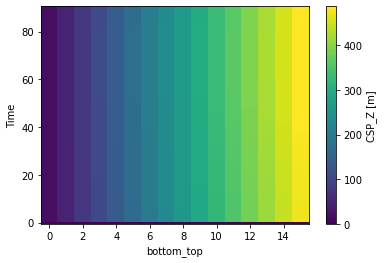

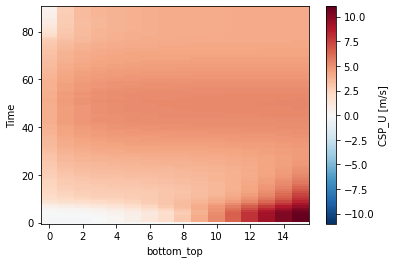

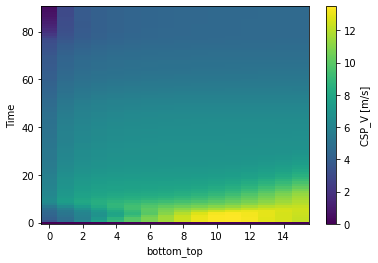

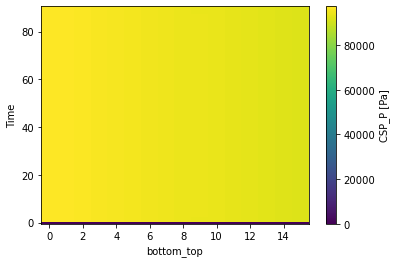

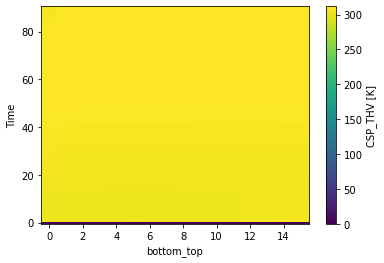

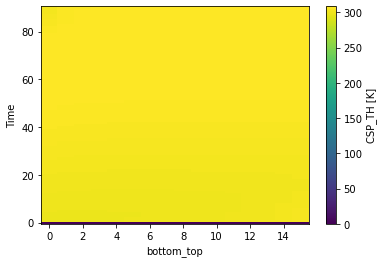

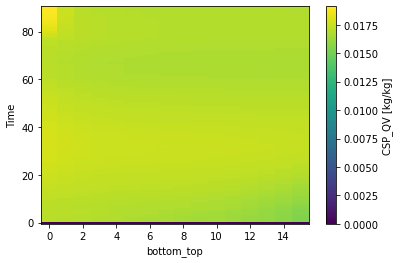

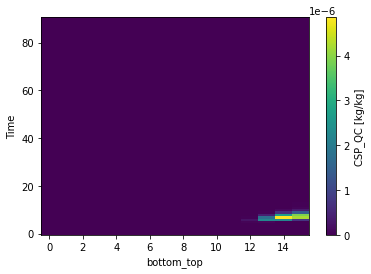

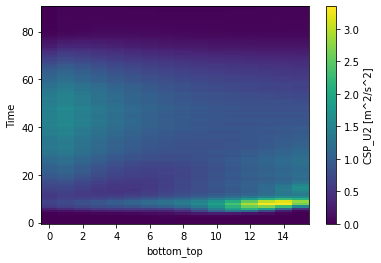

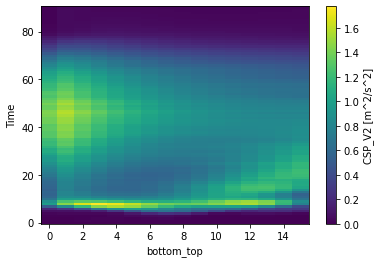

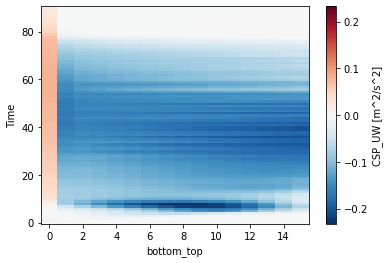

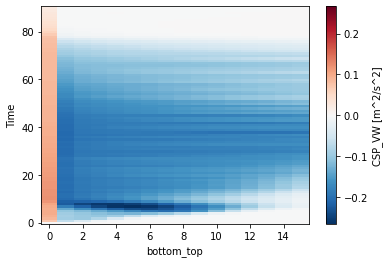

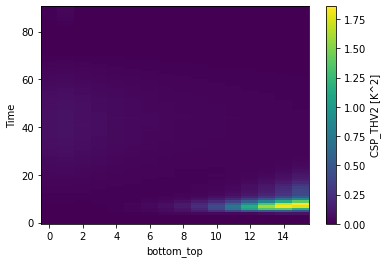

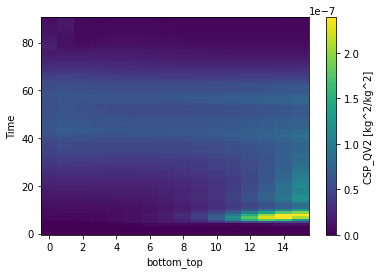

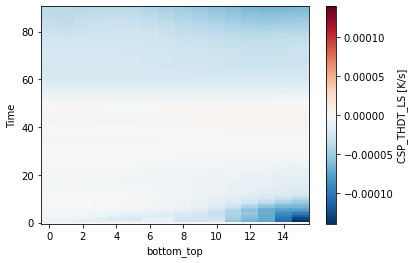

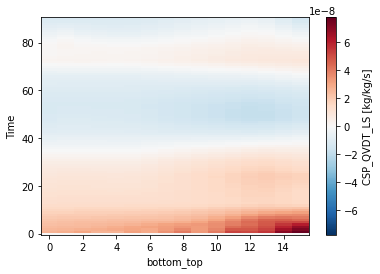

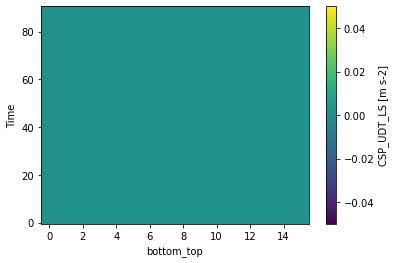

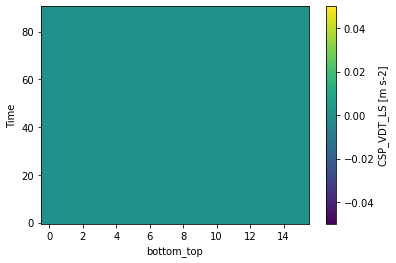

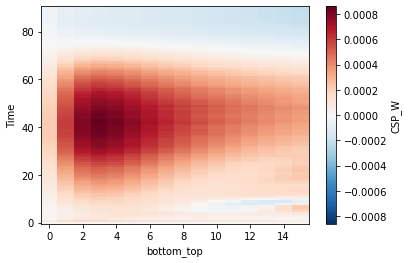

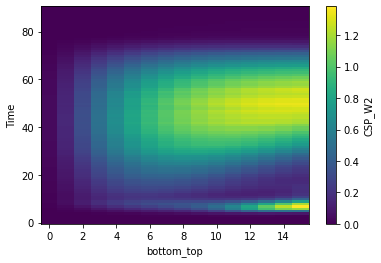

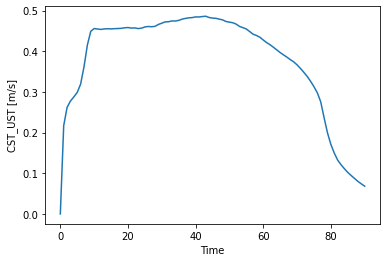

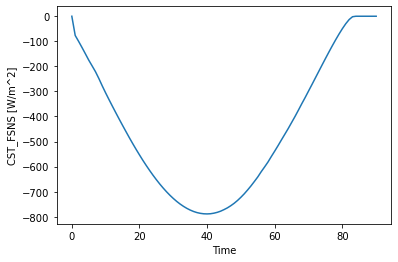

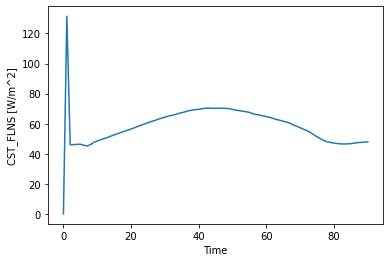

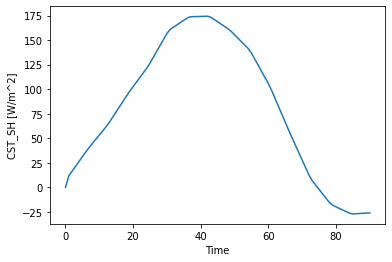

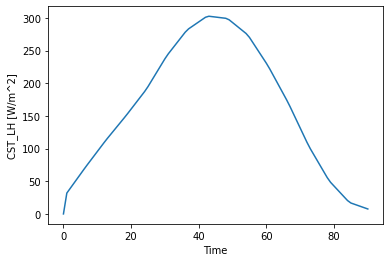

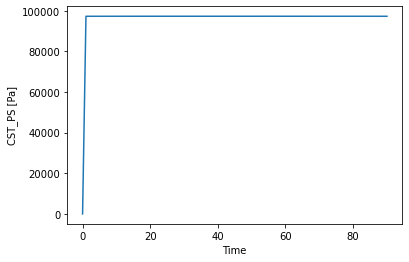

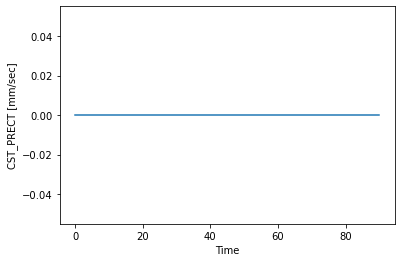

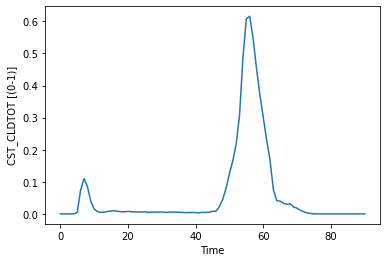

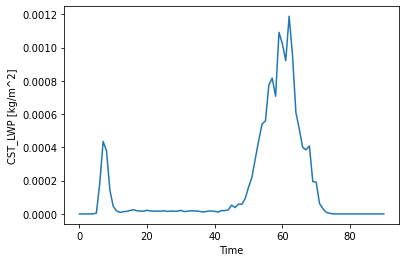

In [27]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat2_d01_2019-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

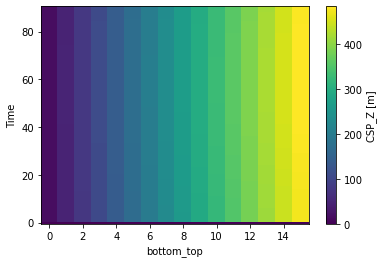

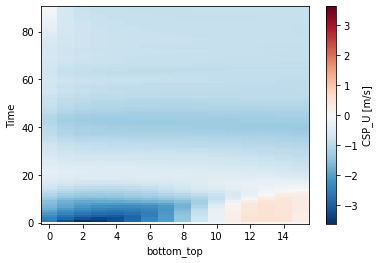

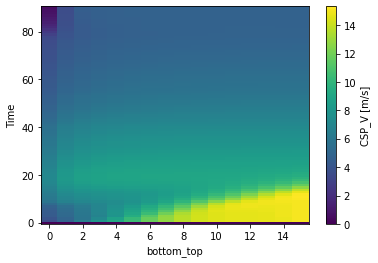

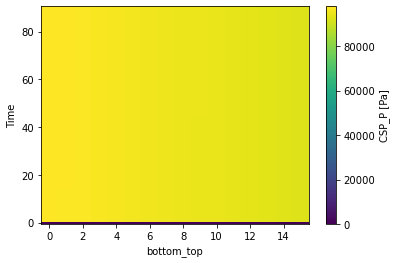

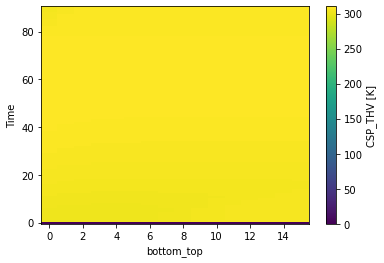

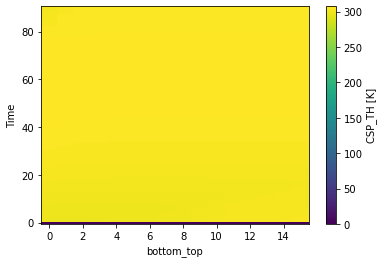

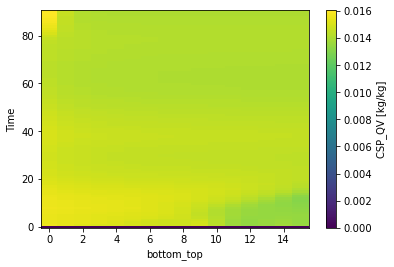

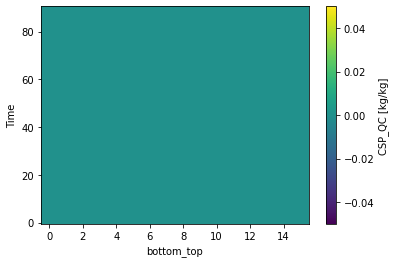

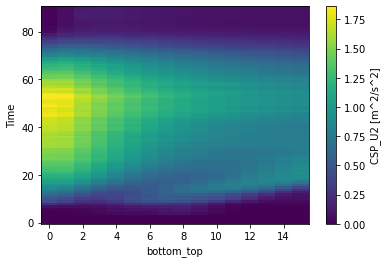

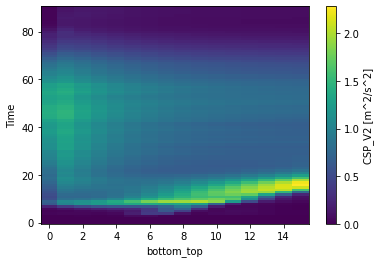

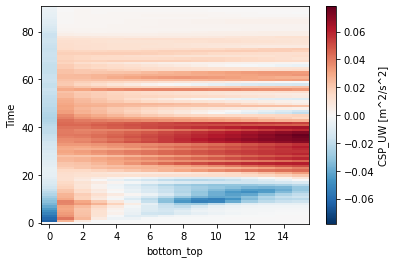

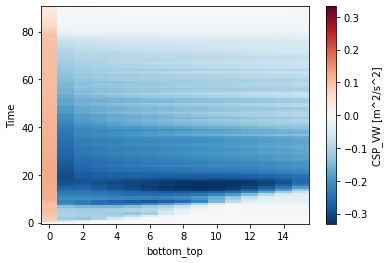

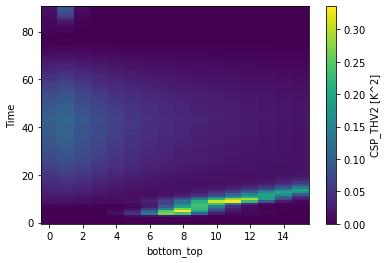

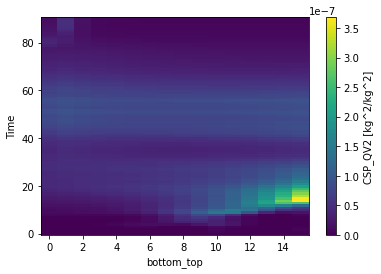

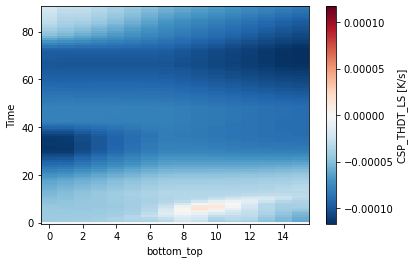

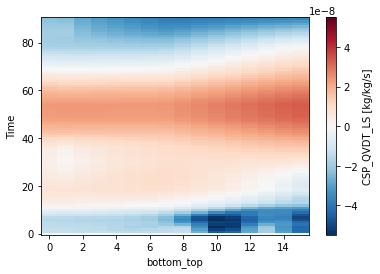

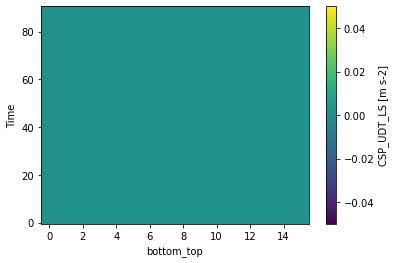

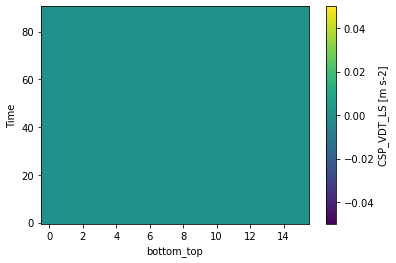

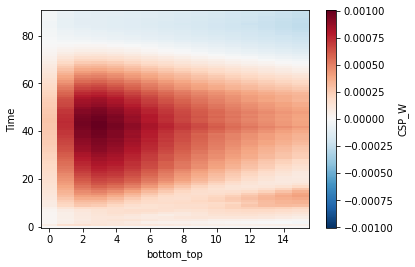

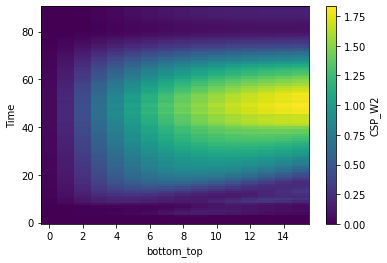

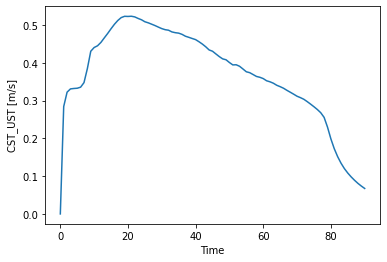

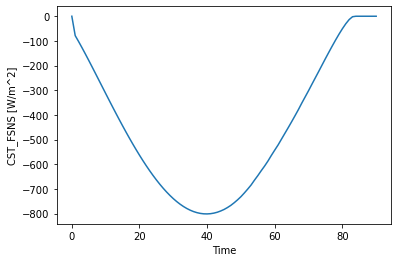

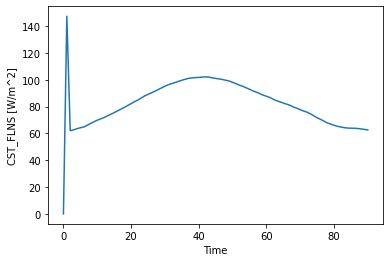

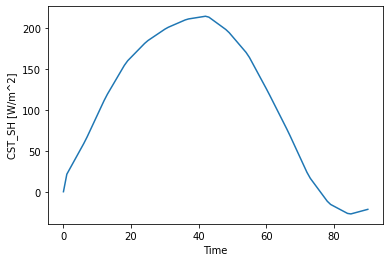

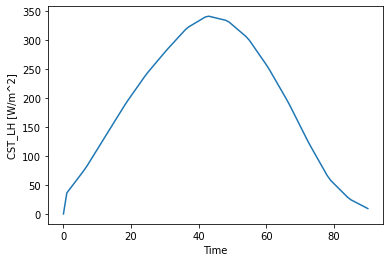

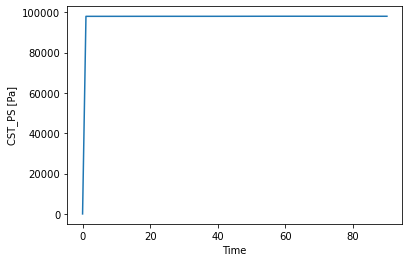

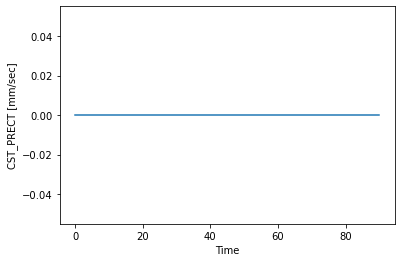

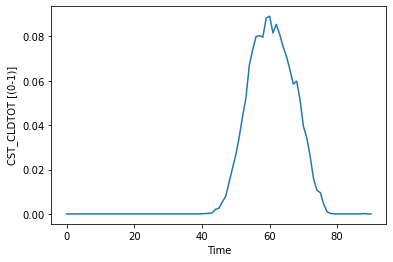

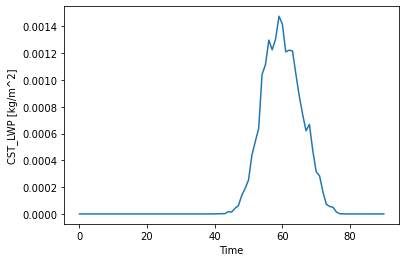

In [28]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat2_d01_2018-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

In [62]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat1_d01_2019-07-04_12:00:00.nc')

In [63]:
test['XLAT'].values.squeeze().shape

(91, 250, 250)

1545772

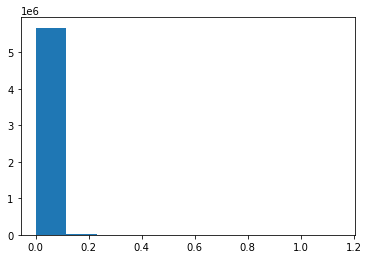

In [64]:
plt.hist(test['XLAT'].values.flatten())
(test['XLAT'].values.flatten() != 0).sum()

(array([5.681566e+06, 4.301000e+03, 9.670000e+02, 3.310000e+02,
        1.850000e+02, 6.600000e+01, 4.400000e+01, 2.400000e+01,
        1.100000e+01, 5.000000e+00]),
 array([0.        , 0.00236877, 0.00473753, 0.0071063 , 0.00947507,
        0.01184384, 0.0142126 , 0.01658137, 0.01895014, 0.0213189 ,
        0.02368767], dtype=float32),
 <BarContainer object of 10 artists>)

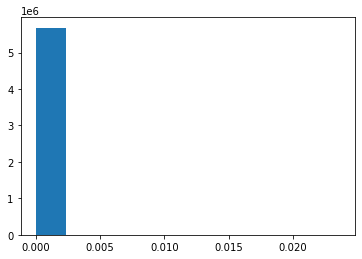

In [57]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat1_d01_2018-07-04_12:00:00.nc')
plt.hist(test['XLAT'].values.flatten())

In [61]:
(test['XLAT'].values.flatten() != 0).sum()

94547

In [65]:
test

<xarray.Dataset>
Dimensions:      (Time: 91, bottom_top: 16, south_north: 250, west_east: 250)
Coordinates:
    XLAT         (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    XLONG        (Time, south_north, west_east) float32 ...
    XTIME        (Time) datetime64[ns] ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Data variables:
    CSP_Z        (Time, bottom_top) float32 ...
    CSP_U        (Time, bottom_top) float32 ...
    CSP_V        (Time, bottom_top) float32 ...
    CSP_P        (Time, bottom_top) float32 ...
    CSP_THV      (Time, bottom_top) float32 ...
    CSP_TH       (Time, bottom_top) float32 ...
    CSP_QV       (Time, bottom_top) float32 ...
    CSP_QC       (Time, bottom_top) float32 ...
    CSP_U2       (Time, bottom_top) float32 ...
    CSP_V2       (Time, bottom_top) float32 ...
    CSP_UW       (Time, bottom_top) float32 ...
    CSP_VW       (Time, bottom_top) float32 ...
    CSP_THV2     (Time, bottom_top) float32 ...
    CSP_QV2      (Time, bottom_top) float32 ...
    CSP_THDT_LS  (Time, bottom_top) float32 ...
    CSP_QVDT_LS  (Time, bottom_top) float32 ...
    CSP_UDT_LS   (Time, bottom_top) float32 ...
    CSP_VDT_LS   (Time, bottom_top) float32 ...
    CSP_W        (Time, bottom_top) float32 ...
    CSP_W2       (Time, bottom_top) float32 ...
    CST_UST      (Time) float32 ...
    CST_FSNS     (Time) float32 ...
    CST_FLNS     (Time) float32 ...
    CST_SH       (Time) float32 ...
    CST_LH       (Time) float32 ...
    CST_PS       (Time) float32 ...
    CST_PRECT    (Time) float32 ...
    CST_CLDTOT   (Time) float32 ...
    CST_LWP      (Time) float32 ...
    Times        (Time) |S19 ...
Attributes:
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-07-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    DY:                                    100.0
    GRIDTYPE:                              C
    DIFF_OPT:                              2
    KM_OPT:                                2
    DAMP_OPT:                              3
    DAMPCOEF:                              0.2
    KHDIF:                                 1.0
    KVDIF:                                 1.0
    MP_PHYSICS:                            8
    RA_LW_PHYSICS:                         4
    RA_SW_PHYSICS:                         4
    SF_SFCLAY_PHYSICS:                     1
    SF_SURFACE_PHYSICS:                    1
    BL_PBL_PHYSICS:                        0
    CU_PHYSICS:                            0
    SF_LAKE_PHYSICS:                       0
    SURFACE_INPUT_SOURCE:                  3
    SST_UPDATE:                            0
    GRID_FDDA:                             0
    GFDDA_INTERVAL_M:                      0
    GFDDA_END_H:                           0
    GRID_SFDDA:                            0
    SGFDDA_INTERVAL_M:                     0
    SGFDDA_END_H:                          0
    HYPSOMETRIC_OPT:                       1
    USE_THETA_M:                           1
    WEST-EAST_PATCH_START_UNSTAG:          1
    WEST-EAST_PATCH_END_UNSTAG:            250
    WEST-EAST_PATCH_START_STAG:            1
    WEST-EAST_PATCH_END_STAG:              251
    SOUTH-NORTH_PATCH_START_UNSTAG:        1
    SOUTH-NORTH_PATCH_END_UNSTAG:          250
    SOUTH-NORTH_PATCH_START_STAG:          1
    SOUTH-NORTH_PATCH_END_STAG:            251
    BOTTOM-TOP_PATCH_START_UNSTAG:         1
    BOTTOM-TOP_PATCH_END_UNSTAG:           226
    BOTTOM-TOP_PATCH_START_STAG:           1
    BOTTOM-TOP_PATCH_END_STAG:             227
    GRID_ID:                               1
    PARENT_ID:                             0
    I_PARENT_START:                        0
    J_PARENT_START:                        0
    PARENT_GRID_RATIO:                     1
    DT: 